#  CHAPTER 13  
***  
## Loading and Preprocessing Data with TensorFlow
***  
- how to efficiently load and preprocess data with TensorFlow.  
  
- So far we have used only datasets that fit in memory(RAM)  
<font color=gray>지금까지 메모리크기 정도의 데이터셋을 썻었다.</font>  
 -  Data API 사용
 -  data also needs to be preprocessed, usually normalize.  
 -  text features, categorical features, and so on. These need to be encoded.  
 (one-hot encoding, bag-of-words encoding, or embeddings)  
 
- preprocessing is to write your own custom preprocessing layers.  
Another is to use the standard preprocessing layers provided by Keras.  
<font color=gray>커스텀 전처리 레이어를 만들거나, 케라스를 사용.</font>   
<br>  
- Data API, the TFRecord format, and how to create custom preprocessing layers and use the standard Keras
- TF Transform (tf.Transform)  
 - Makes it possible to write a single preprocessing function that can be run in batch mode on your full training set, before training (to speed it up)
- TF Datasets (TFDS)  
 - Provides a convenient function to download many common datasets of all kinds  
 
- <font color=gray>이번 장에서 Data API, TFRecord 포멧, 케라스를 이용한 커스텀 전처리 레이어,TF Transform,TF Datasets .</font> 

In [6]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !pip install -q -U tfx==0.21.2
    print("You can safely ignore the package incompatibility errors.")
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "data"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## The Data API  
***  
let’s create a dataset entirely in RAM using <font color=pink>tf.data.Dataset.from_tensor_slices()</font>  
  - elements are all the slices of X (along the first dimension),  
  so this dataset contains 10 items: tensors 0, 1, 2, ..., 9

In [7]:
X = tf.range(10) # any data tensor
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset

<TensorSliceDataset shapes: (), types: tf.int32>

In [8]:
# tf.data.Dataset.range(10) = dataset = tf.data.Dataset.from_tensor_slices(tf.range(10))
dataset = tf.data.Dataset.range(10)

In [9]:
# simply iterate over a dataset’s items 
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(9, shape=(), dtype=int64)


## Chaining Transformations  
***  
Once you have a dataset, you can apply all sorts of transformations to it by calling its transformation methods.    

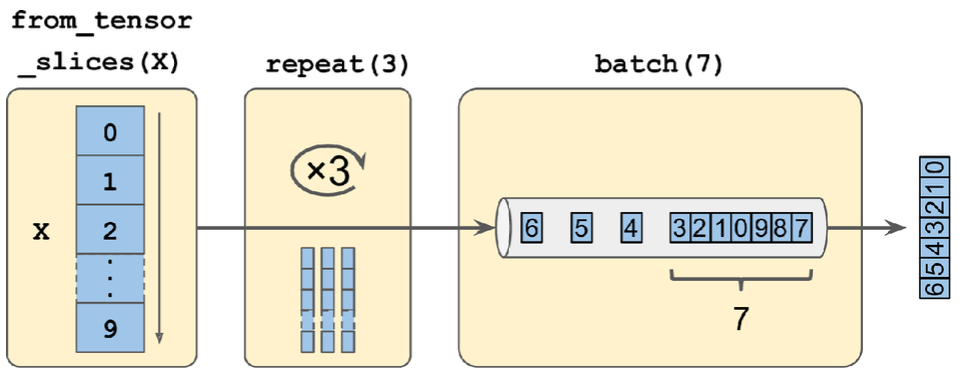  

-  <font color=pink>repeat()</font> method on the <font color=green>original dataset</font>, and it returns a new dataset that will repeat the items of the original dataset three times.  
- <font color=pink>batch()</font> method on this <font color=green>new dataset</font>, and again this creates a new dataset. This one will group the items of the previous dataset in batches of seven items.   
- <font color=pink>drop_remainder=True</font> if you want it to drop this final batch so that all batches have the exact same size.
  
  <font color=gray>repeat()이 기존 데이터셋을 (0\~9) 3배로 만들어 (0\~9,0\~9,0\~9) batch()로 7개씩 끈는다.</font> 


In [10]:
dataset = dataset.repeat(3).batch(7)
for item in dataset:
    print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int64)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int64)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int64)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int64)
tf.Tensor([8 9], shape=(2,), dtype=int64)


 - <font color=pink>map()</font>creates a new dataset with all items doubled.  
   
   <font color=gray>예를들면 map()으로 데이터셋 아이템을 두배로 만들수 있다.</font>

In [11]:
dataset = dataset.map(lambda x: x * 2)    #  Items: [0,2,4,6,8,10,12]

In [12]:
for item in dataset:
    print(item)

tf.Tensor([ 0  2  4  6  8 10 12], shape=(7,), dtype=int64)
tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int64)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int64)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int64)
tf.Tensor([16 18], shape=(2,), dtype=int64)


 - <font color=pink>map()</font> method applies a transformation to each item.  
 - Now deprecated <font color=pink>apply()</font> method applies a transformation to the dataset as a whole 
 - <font color=pink>unbatch()</font>. Each item in the new dataset will be a single-integer tensor instead of a batch of seven integers:  
 - <font color=pink>take()</font> often want to look at just a few items from a dataset.  
   
     <font color=gray> map()으로 각 아이템에 적용. unbatch()로 하나의 integer로 변환 take()로 데이터셋 일부만 보고 싶을때</font> 

In [13]:
#dataset = dataset.apply(tf.data.experimental.unbatch()) # Now deprecated
dataset = dataset.unbatch()

In [14]:
dataset = dataset.filter(lambda x: x < 10)  # keep only items < 10

In [15]:
for item in dataset.take(3):
    print(item)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)


#### Shuffling the Data  
***  
Gradient Descent works best when the instances in the training set are independent and identically distributed (see <font color=green>Chapter 4</font>).   
  
  - dataset containing the integers 0 to 9, repeated 3 times, shuffled using a buffer of size 3 and a random seed of 42, and batched with a batch size of 7:  
 <br> 
  - must specify the buffer size  
    - important to make it large enough, or else shuffling will not be very effective   
    - Just don’t exceed the amount of RAM you have  
    - there’s no need to go beyond the dataset’s size.
  - can call  <font color=pink>repeat()</font> on   a shuffled dataset, by default it will generate a new order at every iteration.  
  (generally a good idea)  
    -  <font color=pink>reshuffle_each_iteration=False</font>  if you prefer to reuse the same order at each iteration.    
  - For a large dataset that does not fit in memory, this simple shuffling-buffer approach may not be sufficient  
   - shuffle the source data itself   
   - split the source data into multiple files, then read them in a random order during training.  
   (Data API makes all this possible in just a few lines of code)
      
 <br>       
  <font color=gray>shuffle()로 데이터섞기  
메모리보다 큰 데이터셋에는 shuffling-buffer 방식이 적절하지 않다.  
 - 소스 데이터 자체를 섞거나  
 - 소스 데이터를 여러 파일로 나누어 트레이닝 할때 랜덤으로 읽어들이게</font> 

In [16]:
tf.random.set_seed(42)

dataset = tf.data.Dataset.range(10).repeat(3)    # 0 to 9, three times
dataset = dataset.shuffle(buffer_size=3, seed=42).batch(7)
for item in dataset:
    print(item)


tf.Tensor([1 3 0 4 2 5 6], shape=(7,), dtype=int64)
tf.Tensor([8 7 1 0 3 2 5], shape=(7,), dtype=int64)
tf.Tensor([4 6 9 8 9 7 0], shape=(7,), dtype=int64)
tf.Tensor([3 1 4 5 2 8 7], shape=(7,), dtype=int64)
tf.Tensor([6 9], shape=(2,), dtype=int64)


# Split the California dataset to multiple CSV files  
***  
 <font color=gray>데이터셋 여러파일로 나누기</font>

In [17]:
# start by loading and preparing the California housing dataset
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_mean = scaler.mean_
X_std = scaler.scale_

 - For a very large dataset that does not fit in memory,   
 you will typically want to split it into many files first,   
 then have TensorFlow read these files in parallel.   
   
   To demonstrate this, let's start by splitting the housing dataset and save it to 20 CSV files:  
   <br><font color=gray>매우큰 데이터는 메모리가 부족하다. 데이터셋을 20개의 CSV파일로 나누어 저장하여 텐서플로우가 병렬 처리 할 수 있게</font>

In [18]:
def save_to_multiple_csv_files(data, name_prefix, header=None, n_parts=10):
    housing_dir = os.path.join("datasets", "housing")
    os.makedirs(housing_dir, exist_ok=True)
    path_format = os.path.join(housing_dir, "my_{}_{:02d}.csv")

    filepaths = []
    m = len(data)
    for file_idx, row_indices in enumerate(np.array_split(np.arange(m), n_parts)):
        part_csv = path_format.format(name_prefix, file_idx)
        filepaths.append(part_csv)
        with open(part_csv, "wt", encoding="utf-8") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths

In [19]:
train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = housing.feature_names + ["MedianHouseValue"]
header = ",".join(header_cols)

train_filepaths = save_to_multiple_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_multiple_csv_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_multiple_csv_files(test_data, "test", header, n_parts=10)

In [20]:
# in pd
import pandas as pd

pd.read_csv(train_filepaths[0]).head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
0,3.5214,15.0,3.049945,1.106548,1447.0,1.605993,37.63,-122.43,1.442
1,5.3275,5.0,6.490060,0.991054,3464.0,3.443340,33.69,-117.39,1.687
2,3.1000,29.0,7.542373,1.591525,1328.0,2.250847,38.44,-122.98,1.621
3,7.1736,12.0,6.289003,0.997442,1054.0,2.695652,33.55,-117.70,2.621
4,2.0549,13.0,5.312457,1.085092,3297.0,2.244384,33.93,-116.93,0.956


In [21]:
# in text
with open(train_filepaths[0]) as f:
    for i in range(5):
        print(f.readline(), end="")

MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
3.5214,15.0,3.0499445061043287,1.106548279689234,1447.0,1.6059933407325193,37.63,-122.43,1.442
5.3275,5.0,6.490059642147117,0.9910536779324056,3464.0,3.4433399602385686,33.69,-117.39,1.687
3.1,29.0,7.5423728813559325,1.5915254237288134,1328.0,2.2508474576271187,38.44,-122.98,1.621
7.1736,12.0,6.289002557544757,0.9974424552429667,1054.0,2.6956521739130435,33.55,-117.7,2.621


In [22]:
train_filepaths

['datasets/housing/my_train_00.csv',
 'datasets/housing/my_train_01.csv',
 'datasets/housing/my_train_02.csv',
 'datasets/housing/my_train_03.csv',
 'datasets/housing/my_train_04.csv',
 'datasets/housing/my_train_05.csv',
 'datasets/housing/my_train_06.csv',
 'datasets/housing/my_train_07.csv',
 'datasets/housing/my_train_08.csv',
 'datasets/housing/my_train_09.csv',
 'datasets/housing/my_train_10.csv',
 'datasets/housing/my_train_11.csv',
 'datasets/housing/my_train_12.csv',
 'datasets/housing/my_train_13.csv',
 'datasets/housing/my_train_14.csv',
 'datasets/housing/my_train_15.csv',
 'datasets/housing/my_train_16.csv',
 'datasets/housing/my_train_17.csv',
 'datasets/housing/my_train_18.csv',
 'datasets/housing/my_train_19.csv']

## Building an Input Pipeline  
***  
 - <font color=pink>list_files()</font> returns a dataset that shuffles the file paths.
  - <font color=pink>shuffle=False</font> if you do not want that. 

 - <font color=pink>interleave()</font> read from five files at a time and interleave their lines (skipping the first line of each file, which is the header row, using the skip() method):

In [23]:
filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed=42)    # list_files()

In [24]:
for filepath in filepath_dataset:
    print(filepath)

tf.Tensor(b'datasets/housing/my_train_15.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_08.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_03.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_01.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_10.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_05.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_19.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_16.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_02.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_09.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_00.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_07.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_12.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_04.csv', shape=(), dtype=string)
tf.Ten

- create a dataset that will pull five file paths from the filepath_dataset. or each one it will call the function you gave it (a lambda in this example) to create a new dataset (in this case a TextLineDataset)  
 -   <font color=pink>interleave()</font> does not use parallelism; it just reads one line at a time from each file, sequentially.  
 - read files in parallel, you can set the <font color=pink>num_parallel_calls</font> argument to the number of threads you want.  
 -  <font color=pink>tf.data.experimental.AUTOTUNE</font> to make TensorFlow choose the right number of threads dynamically based on the available CPU.
- there will be 7 datasets in all: 1 filepath dataset + 1 interleave dataset + 5 TextLineDatasets created internally by the interleave dataset.

In [25]:
n_readers = 5
dataset = filepath_dataset.interleave(    # interleave()
    lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
    cycle_length=n_readers)

In [26]:
# these are just byte strings; we need to parse them and scale the data.
for line in dataset.take(5):
    print(line.numpy())

b'4.6477,38.0,5.03728813559322,0.911864406779661,745.0,2.5254237288135593,32.64,-117.07,1.504'
b'8.72,44.0,6.163179916317992,1.0460251046025104,668.0,2.794979079497908,34.2,-118.18,4.159'
b'3.8456,35.0,5.461346633416459,0.9576059850374065,1154.0,2.8778054862842892,37.96,-122.05,1.598'
b'3.3456,37.0,4.514084507042254,0.9084507042253521,458.0,3.2253521126760565,36.67,-121.7,2.526'
b'3.6875,44.0,4.524475524475524,0.993006993006993,457.0,3.195804195804196,34.04,-118.15,1.625'


In [27]:
# field 4 is interpreted as a string.
record_defaults=[0, np.nan, tf.constant(np.nan, dtype=tf.float64), "Hello", tf.constant([])]
parsed_fields = tf.io.decode_csv('1,2,3,4,5', record_defaults)
parsed_fields

[<tf.Tensor: shape=(), dtype=int32, numpy=1>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.0>,
 <tf.Tensor: shape=(), dtype=float64, numpy=3.0>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'4'>,
 <tf.Tensor: shape=(), dtype=float32, numpy=5.0>]

In [28]:
# all missing fields are replaced with their default value, when provided:
parsed_fields = tf.io.decode_csv(',,,,5', record_defaults)
parsed_fields

[<tf.Tensor: shape=(), dtype=int32, numpy=0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=nan>,
 <tf.Tensor: shape=(), dtype=float64, numpy=nan>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'Hello'>,
 <tf.Tensor: shape=(), dtype=float32, numpy=5.0>]

In [29]:
# The 5th field is compulsory (since we provided tf.constant([]) as the "default value"), 
# so we get an exception if we do not provide it:
try:
    parsed_fields = tf.io.decode_csv(',,,,', record_defaults)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

Field 4 is required but missing in record 0! [Op:DecodeCSV]


In [30]:
# number of fields should match exactly the number of fields in the record_defaults:
try:
    parsed_fields = tf.io.decode_csv('1,2,3,4,5,6,7', record_defaults)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

Expect 5 fields but have 7 in record 0 [Op:DecodeCSV]


#### Preprocessing the Data  
***  
 - <font color=pink>preprocess()</font> function takes one CSV line and starts by parsing it  
 - <font color=pink>tf.io.decode_csv()</font> first is the line to parse, and the second is an array containing the default value for each column in the CSV file.  
  - This array tells TensorFlow not only the default value for each column, but also the number of columns and their types.  
  - all feature columns are floats and that missing values should default to 0,  
  - so it will raise an exception if it encounters a missing value.  
- <font color=pink>decode_csv()</font>  returns a list of scalar tensors (one per column)
- we need to return 1D tensor arrays. So we call <font color=pink>tf.stack()</font> (except for the last one (the target))  
- do the same for the target value (makes it a 1D tensor array with a single value, rather than a scalar tensor)  
-  scale the input features by subtracting the feature means and then dividing by the feature standard deviations.

In [31]:

n_inputs = 8 # X_train.shape[-1]

@tf.function
def preprocess(line):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(fields[:-1])
    y = tf.stack(fields[-1:])
    return (x - X_mean) / X_std, y

In [32]:
preprocess(b'4.2083,44.0,5.3232,0.9171,846.0,2.3370,37.47,-122.2,2.782')

(<tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([ 0.16579157,  1.216324  , -0.05204565, -0.39215982, -0.5277444 ,
        -0.2633488 ,  0.8543046 , -1.3072058 ], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.782], dtype=float32)>)

# Putting Everything Together  
***  
 - load California housing data from multiple CSV files, preprocess it, shuffle it, optionally repeat it, and batch it.  
 
 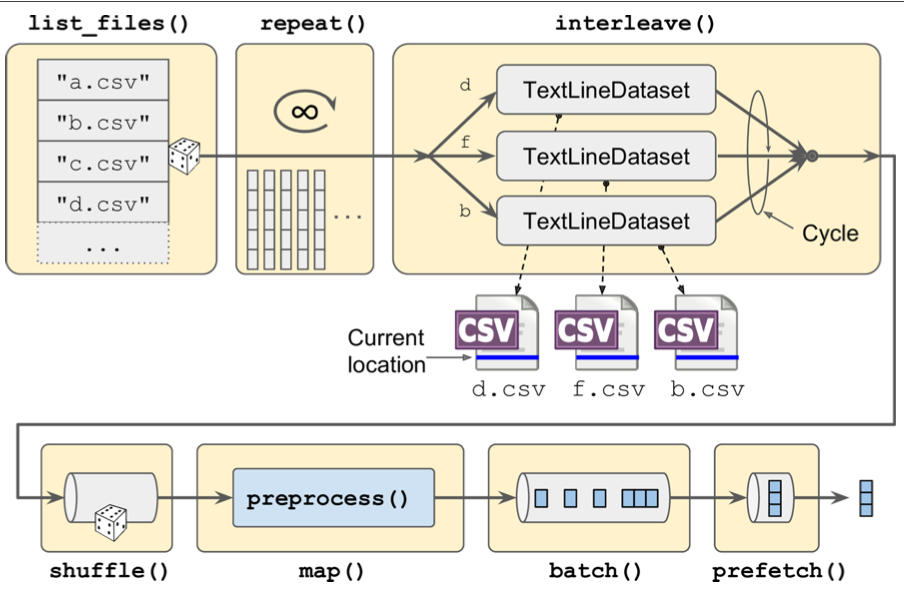  
 
 - 

In [33]:
def csv_reader_dataset(filepaths, repeat=1, n_readers=5,
                       n_read_threads=None, shuffle_buffer_size=10000,
                       n_parse_threads=5, batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths).repeat(repeat)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers, num_parallel_calls=n_read_threads)
    dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

# Prefetching
***  
 - calling <font color=pink>prefetch(1)</font> at the end, we are creating a dataset that will do its best to always be one batch ahead.  
  - while our training algorithm is working on one batch, the dataset will already be working in parallel on getting the next batch ready (e.g., reading the data from disk and preprocessing it)  
    
 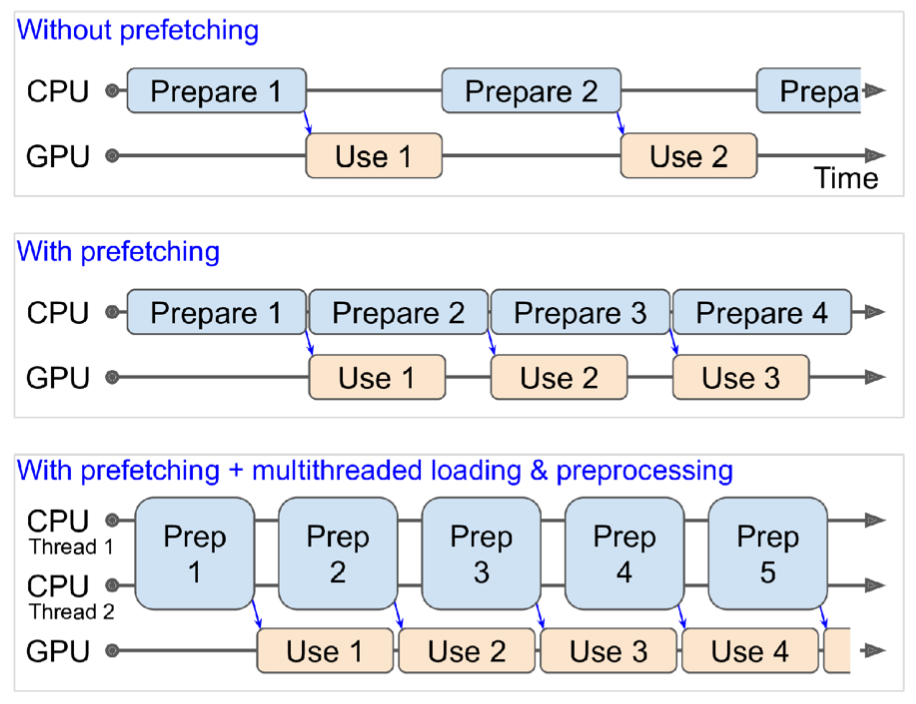  
    
- in particular, a large amount of RAM is crucial for computer vision.  
- memory bandwidth; this is the number of gigabytes of data it can get into or out of its RAM per second.  
<br>  
- If the dataset is small enough to fit in memory, you can significantly speed up training by using the dataset’s <font color=pink>cache()</font> method to cache its content to RAM.  
 -  should generally do this after loading and preprocessing the data, but before shuffling, repeating, batching, and prefetching.  
 - instance will only be read and preprocessed once (instead of once per epoch)

 - but the data will still be shuffled differently at each epoch, and the next batch will still be prepared in advance.  
 
- <font color=pink>concatenate(), zip(), window(), reduce(), shard(), flat_map(), and padded_batch(). from_generator() and from_tensors()</font>, which create a new dataset from a Python generator or a list of tensors,
   

#### Using the Dataset with tf.keras  
***  
 - <font color=pink>csv_reader_dataset</font> create a dataset for the training set.  
 - 

In [34]:
tf.random.set_seed(42)

train_set = csv_reader_dataset(train_filepaths, batch_size=3)
for X_batch, y_batch in train_set.take(2):
    print("X =", X_batch)
    print("y =", y_batch)
    print()

X = tf.Tensor(
[[ 0.5804519  -0.20762321  0.05616303 -0.15191229  0.01343246  0.00604472
   1.2525111  -1.3671792 ]
 [ 5.818099    1.8491895   1.1784915   0.28173092 -1.2496178  -0.3571987
   0.7231292  -1.0023477 ]
 [-0.9253566   0.5834586  -0.7807257  -0.28213993 -0.36530012  0.27389365
  -0.76194876  0.72684526]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[1.752]
 [1.313]
 [1.535]], shape=(3, 1), dtype=float32)

X = tf.Tensor(
[[-0.8324941   0.6625668  -0.20741376 -0.18699841 -0.14536144  0.09635526
   0.9807942  -0.67250353]
 [-0.62183803  0.5834586  -0.19862501 -0.3500319  -1.1437552  -0.3363751
   1.107282   -0.8674123 ]
 [ 0.8683102   0.02970133  0.3427381  -0.29872298  0.7124906   0.28026953
  -0.72915536  0.86178064]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[0.919]
 [1.028]
 [2.182]], shape=(3, 1), dtype=float32)



In [35]:
train_set = csv_reader_dataset(train_filepaths, repeat=None)
valid_set = csv_reader_dataset(valid_filepaths)
test_set = csv_reader_dataset(test_filepaths)

In [36]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1),
])

In [37]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

In [38]:
batch_size = 32
model.fit(train_set, steps_per_epoch=len(X_train) // batch_size, epochs=10,
          validation_data=valid_set)

Epoch 1/10
362/362 [==============================] - 1s 3ms/step - loss: 1.4679 - val_loss: 21.5124
Epoch 2/10
362/362 [==============================] - 1s 2ms/step - loss: 0.8735 - val_loss: 0.6648
Epoch 3/10
362/362 [==============================] - 1s 2ms/step - loss: 0.6317 - val_loss: 0.6196
Epoch 4/10
362/362 [==============================] - 2s 5ms/step - loss: 0.5933 - val_loss: 0.5669
Epoch 5/10
362/362 [==============================] - 2s 5ms/step - loss: 0.5629 - val_loss: 0.5402
Epoch 6/10
362/362 [==============================] - 2s 5ms/step - loss: 0.5693 - val_loss: 0.5209
Epoch 7/10
362/362 [==============================] - 1s 3ms/step - loss: 0.5231 - val_loss: 0.6130
Epoch 8/10
362/362 [==============================] - 1s 4ms/step - loss: 0.5074 - val_loss: 0.4818
Epoch 9/10
362/362 [==============================] - 1s 3ms/step - loss: 0.4963 - val_loss: 0.4904
Epoch 10/10
362/362 [==============================] - 1s 3ms/step - loss: 0.5023 - val_loss: 0.458

In [39]:
model.evaluate(test_set, steps=len(X_test) // batch_size)

161/161 [==============================] - 0s 3ms/step - loss: 0.4788


0.4787752032279968

In [40]:
new_set = test_set.map(lambda X, y: X) # we could instead just pass test_set, Keras would ignore the labels
X_new = X_test
model.predict(new_set, steps=len(X_new) // batch_size)

array([[2.3576405],
       [2.255291 ],
       [1.4437604],
       ...,
       [0.5654393],
       [3.9442453],
       [1.0232248]], dtype=float32)

In [41]:
optimizer = keras.optimizers.Nadam(lr=0.01)
loss_fn = keras.losses.mean_squared_error

n_epochs = 5
batch_size = 32
n_steps_per_epoch = len(X_train) // batch_size
total_steps = n_epochs * n_steps_per_epoch
global_step = 0
for X_batch, y_batch in train_set.take(total_steps):
    global_step += 1
    print("\rGlobal step {}/{}".format(global_step, total_steps), end="")
    with tf.GradientTape() as tape:
        y_pred = model(X_batch)
        main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
        loss = tf.add_n([main_loss] + model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

Global step 1810/1810

In [42]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [43]:
optimizer = keras.optimizers.Nadam(lr=0.01)
loss_fn = keras.losses.mean_squared_error

@tf.function
def train(model, n_epochs, batch_size=32,
          n_readers=5, n_read_threads=5, shuffle_buffer_size=10000, n_parse_threads=5):
    train_set = csv_reader_dataset(train_filepaths, repeat=n_epochs, n_readers=n_readers,
                       n_read_threads=n_read_threads, shuffle_buffer_size=shuffle_buffer_size,
                       n_parse_threads=n_parse_threads, batch_size=batch_size)
    for X_batch, y_batch in train_set:
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

train(model, 5)

In [44]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [45]:
optimizer = keras.optimizers.Nadam(lr=0.01)
loss_fn = keras.losses.mean_squared_error

@tf.function
def train(model, n_epochs, batch_size=32,
          n_readers=5, n_read_threads=5, shuffle_buffer_size=10000, n_parse_threads=5):
    train_set = csv_reader_dataset(train_filepaths, repeat=n_epochs, n_readers=n_readers,
                       n_read_threads=n_read_threads, shuffle_buffer_size=shuffle_buffer_size,
                       n_parse_threads=n_parse_threads, batch_size=batch_size)
    n_steps_per_epoch = len(X_train) // batch_size
    total_steps = n_epochs * n_steps_per_epoch
    global_step = 0
    for X_batch, y_batch in train_set.take(total_steps):
        global_step += 1
        if tf.equal(global_step % 100, 0):
            tf.print("\rGlobal step", global_step, "/", total_steps)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

train(model, 5)

Global step 100 / 1810
Global step 200 / 1810
Global step 300 / 1810
Global step 400 / 1810
Global step 500 / 1810
Global step 600 / 1810
Global step 700 / 1810
Global step 800 / 1810
Global step 900 / 1810
Global step 1000 / 1810
Global step 1100 / 1810
Global step 1200 / 1810
Global step 1300 / 1810
Global step 1400 / 1810
Global step 1500 / 1810
Global step 1600 / 1810
Global step 1700 / 1810
Global step 1800 / 1810


 -  short description of each method in the Dataset class:

In [46]:
for m in dir(tf.data.Dataset):
    if not (m.startswith("_") or m.endswith("_")):
        func = getattr(tf.data.Dataset, m)
        if hasattr(func, "__doc__"):
            print("● {:21s}{}".format(m + "()", func.__doc__.split("\n")[0]))


● apply()              Applies a transformation function to this dataset.
● as_numpy_iterator()  Returns an iterator which converts all elements of the dataset to numpy.
● batch()              Combines consecutive elements of this dataset into batches.
● cache()              Caches the elements in this dataset.
● concatenate()        Creates a `Dataset` by concatenating the given dataset with this dataset.
● element_spec()       The type specification of an element of this dataset.
● enumerate()          Enumerates the elements of this dataset.
● filter()             Filters this dataset according to `predicate`.
● flat_map()           Maps `map_func` across this dataset and flattens the result.
● from_generator()     Creates a `Dataset` whose elements are generated by `generator`.
● from_tensor_slices() Creates a `Dataset` whose elements are slices of the given tensors.
● from_tensors()       Creates a `Dataset` with a single element, comprising the given tensors.
● interleave()      

# The TFRecord binary format  
***  
 - TFRecord format is TensorFlow’s preferred format for storing large amounts of data and reading it efficiently.  
 - A TFRecord file is just a list of binary records. You can create one using <font color=pink>tf.io.TFRecordWriter</font> class.  
 - <font color=pink>tf.data.TFRecordDataset</font>  to read one or more TFRecord files:

In [47]:
with tf.io.TFRecordWriter("my_data.tfrecord") as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")

In [48]:
filepaths = ["my_data.tfrecord"]
dataset = tf.data.TFRecordDataset(filepaths)
for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


 - You can read multiple TFRecord files with just one TFRecordDataset. By default it will read them one at a time, but if you set <font color=pink>num_parallel_reads=3</font> , it will read 3 at a time in parallel and interleave their records:  
 - By default, a TFRecordDataset will read files one by one, but you can make it read multiple files in parallel and interleave their records by setting <font color=pink>num_parallel_reads</font>  
  - same result by using <font color=pink>list_files()</font> and <font color=pink>interleave()</font> as we did earlier to read multiple CSV files.

In [49]:
filepaths = ["my_test_{}.tfrecord".format(i) for i in range(5)]
for i, filepath in enumerate(filepaths):
    with tf.io.TFRecordWriter(filepath) as f:
        for j in range(3):
            f.write("File {} record {}".format(i, j).encode("utf-8"))

dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=3)
for item in dataset:
    print(item)

tf.Tensor(b'File 0 record 0', shape=(), dtype=string)
tf.Tensor(b'File 1 record 0', shape=(), dtype=string)
tf.Tensor(b'File 2 record 0', shape=(), dtype=string)
tf.Tensor(b'File 0 record 1', shape=(), dtype=string)
tf.Tensor(b'File 1 record 1', shape=(), dtype=string)
tf.Tensor(b'File 2 record 1', shape=(), dtype=string)
tf.Tensor(b'File 0 record 2', shape=(), dtype=string)
tf.Tensor(b'File 1 record 2', shape=(), dtype=string)
tf.Tensor(b'File 2 record 2', shape=(), dtype=string)
tf.Tensor(b'File 3 record 0', shape=(), dtype=string)
tf.Tensor(b'File 4 record 0', shape=(), dtype=string)
tf.Tensor(b'File 3 record 1', shape=(), dtype=string)
tf.Tensor(b'File 4 record 1', shape=(), dtype=string)
tf.Tensor(b'File 3 record 2', shape=(), dtype=string)
tf.Tensor(b'File 4 record 2', shape=(), dtype=string)


#### Compressed TFRecord Files  
***  
- It can sometimes be useful to compress your TFRecord files, 

- especially if they need to be loaded via a network connection. 

- You can create a compressed TFRecord file by setting the <font color=pink>options</font> argument

In [50]:
options = tf.io.TFRecordOptions(compression_type="GZIP")
with tf.io.TFRecordWriter("my_compressed.tfrecord", options) as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")

 ***
 -  When reading a compressed TFRecord file, you need to specify the compression type:


In [51]:
dataset = tf.data.TFRecordDataset(["my_compressed.tfrecord"],
                                  compression_type="GZIP")
for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


# A Brief Introduction to Protocol Buffers  
***  
 -  TFRecord files usually contain serialized protocol buffers (also called protobufs).

 - For this section you need to install protobuf.  
 https://developers.google.com/protocol-buffers/docs/downloads   
 - In general you will not have to do so when using TensorFlow, as it comes with functions to create and parse protocol buffers of type tf.train.Example, which are generally sufficient.   
 However, in this section we will learn about protocol buffers by creating our own simple protobuf definition, so we need the protobuf compiler (protoc): we will use it to compile the protobuf definition to a Python module that we can then use in our code.
First let's write a simple protobuf definition:  

<br>  
 
 1. definition says we are using version 3 of the protobuf format  
 2. The numbers 1, 2, and 3 are the field identifiers:   
 3. https://homl.info/protobuf.

In [52]:
import google.protobuf

In [53]:
%%writefile person.proto
syntax = "proto3";
message Person {
  string name = 1;
  int32 id = 2;
  repeated string email = 3;
}

Overwriting person.proto


 - And let's compile it (the --descriptor_set_out and --include_imports options are only required for the <font color=pink>tf.io.decode_proto()</font> example below):

In [54]:
!protoc person.proto --python_out=. --descriptor_set_out=person.desc --include_imports

In [55]:
!ls person*

person.desc   person.proto  person_pb2.py


 -  = 1", " = 2" markers on each element identify the unique "tag" that field uses in the binary encoding.  
 - If you were to try to assign a field that isn't defined in the .proto file, an AttributeError would be raised. 

In [56]:
from person_pb2 import Person # import the generated access class

person = Person(name="Al", id=123, email=["a@b.com"])  # create a Person
print(person)  # display the Person

name: "Al"
id: 123
email: "a@b.com"



In [57]:
person.name  # read a field

'Al'

In [58]:
person.name = "Alice"  # modify a field

In [59]:
person.email[0]  # repeated fields can be accessed like arrays

'a@b.com'

In [60]:
person.email.append("c@d.com")  # add an email address

In [61]:
s = person.SerializeToString()  # serialize to a byte string
s

b'\n\x05Alice\x10{\x1a\x07a@b.com\x1a\x07c@d.com'

In [62]:
person2 = Person()  # create a new Person
person2.ParseFromString(s)  # parse the byte string (27 bytes)

27

In [63]:
person == person2  # now they are equal

True

#### Custom protobuf  
***  
In rare cases, you may want to parse a custom protobuf (like the one we just created) in TensorFlow. For this you can use the <font color=pink>tf.io.decode_proto()</font> function:  
- For more details, see the https://www.tensorflow.org/api_docs/python/tf/io/decode_proto documentation.

In [64]:
person_tf = tf.io.decode_proto(
    bytes=s,
    message_type="Person",
    field_names=["name", "id", "email"],
    output_types=[tf.string, tf.int32, tf.string],
    descriptor_source="person.desc")

person_tf.values

[<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Alice'], dtype=object)>,
 <tf.Tensor: shape=(1,), dtype=int32, numpy=array([123], dtype=int32)>,
 <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>]

# TensorFlow Protobufs  
***
 - It contains a list of named features, where each feature can either be a list  
 (of byte strings, a list of floats, or a list of integers)
 - Here is the definition of the tf.train.Example protobuf:  
  - [packed = true] is used for repeated numerical fields, for a more efficient encoding. 

In [65]:

syntax = "proto3";

message BytesList { repeated bytes value = 1; }
message FloatList { repeated float value = 1 [packed = true]; }
message Int64List { repeated int64 value = 1 [packed = true]; }
message Feature {
    oneof kind {
        BytesList bytes_list = 1;
        FloatList float_list = 2;
        Int64List int64_list = 3;
    }
};
message Features { map<string, Feature> feature = 1; };
message Example { Features features = 1; };

SyntaxError: invalid syntax (<ipython-input-65-e29d527d264e>, line 3)

In [66]:
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example
# BytesList = tf.train.BytesList
# FloatList = tf.train.FloatList
# Int64List = tf.train.Int64List
# Feature = tf.train.Feature
# Features = tf.train.Features
# Example = tf.train.Example

person_example = Example(
    features=Features(
        feature={
            "name": Feature(bytes_list=BytesList(value=[b"Alice"])),
            "id": Feature(int64_list=Int64List(value=[123])),
            "emails": Feature(bytes_list=BytesList(value=[b"a@b.com", b"c@d.com"]))
        }))

with tf.io.TFRecordWriter("my_contacts.tfrecord") as f:
    f.write(person_example.SerializeToString())

#### Loading and Parsing Examples  
***  
 - To load the serialized Example protobufs, we will use a <font color=pink>tf.data.TFRecordDataset</font>  
 - parse each Example using <font color=pink>tf.io.parse_single_example()</font>   
<br>
 - BytesList can contain any binary data you want, including any serialized object.  
  - use <font color=pink>tf.io.encode_jpeg()</font> to encode an image using the JPEG format and put this binary data in a BytesList.  
    - <font color=pink>tf.io.decode_jpeg()</font> to parse the data and get the original image (or you can use <font color=pink>tf.io.decode_image()</font>, which can decode any BMP, GIF, JPEG, or PNG image.  
  - Also store any tensor you want in a BytesList by serializing the tensor using <font color=pink>tf.io.serialize_tensor()</font>.   

- Instead of parsing examples one by one using <font color=pink>tf.io.parse_single_example()</font>, you may want to parse them batch by batch using <font color=pink>tf.io.parse_example()</font>:


In [67]:
feature_description = {
    "name": tf.io.FixedLenFeature([], tf.string, default_value=""),
    "id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "emails": tf.io.VarLenFeature(tf.string),
}
for serialized_example in tf.data.TFRecordDataset(["my_contacts.tfrecord"]):
    parsed_example = tf.io.parse_single_example(serialized_example,
                                                feature_description)

In [68]:
# fixed-length features are parsed as regular tensors, 
# but the variable-length features are parsed as sparse tensors.
parsed_example

{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x1391e0650>,
 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>,
 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}

In [69]:
parsed_example["emails"].values[0]

<tf.Tensor: shape=(), dtype=string, numpy=b'a@b.com'>

In [70]:
tf.sparse.to_dense(parsed_example["emails"], default_value=b"")


<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

In [71]:
parsed_example["emails"].values

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

#### Putting Images in TFRecords   
***  
- $ pip install pillow

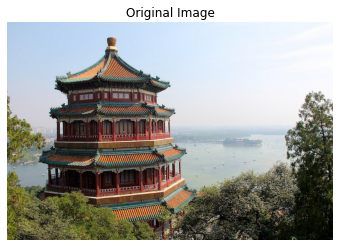

In [72]:
from sklearn.datasets import load_sample_images

img = load_sample_images()["images"][0]
plt.imshow(img)
plt.axis("off")
plt.title("Original Image")
plt.show()

In [73]:
data = tf.io.encode_jpeg(img)
example_with_image = Example(features=Features(feature={
    "image": Feature(bytes_list=BytesList(value=[data.numpy()]))}))
serialized_example = example_with_image.SerializeToString()
# then save to TFRecord

In [74]:
feature_description = { "image": tf.io.VarLenFeature(tf.string) }
example_with_image = tf.io.parse_single_example(serialized_example, feature_description)
decoded_img = tf.io.decode_jpeg(example_with_image["image"].values[0])

 - Or use decode_image() which supports BMP, GIF, JPEG and PNG formats:

In [75]:
decoded_img = tf.io.decode_image(example_with_image["image"].values[0])

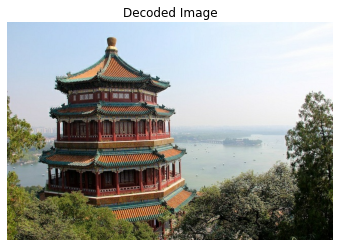

In [76]:
plt.imshow(decoded_img)
plt.title("Decoded Image")
plt.axis("off")
plt.show()

#### Putting Tensors and Sparse Tensors in TFRecords  
***  
 - Tensors can be serialized and parsed easily using <font color=pink>tf.io.serialize_tensor()</font> and <font color=pink>tf.io.parse_tensor()</font>:

In [77]:
t = tf.constant([[0., 1.], [2., 3.], [4., 5.]])
s = tf.io.serialize_tensor(t)
s

<tf.Tensor: shape=(), dtype=string, numpy=b'\x08\x01\x12\x08\x12\x02\x08\x03\x12\x02\x08\x02"\x18\x00\x00\x00\x00\x00\x00\x80?\x00\x00\x00@\x00\x00@@\x00\x00\x80@\x00\x00\xa0@'>

In [78]:
tf.io.parse_tensor(s, out_type=tf.float32)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[0., 1.],
       [2., 3.],
       [4., 5.]], dtype=float32)>

In [79]:
serialized_sparse = tf.io.serialize_sparse(parsed_example["emails"])
serialized_sparse

<tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'\x08\t\x12\x08\x12\x02\x08\x02\x12\x02\x08\x01"\x10\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00',
       b'\x08\x07\x12\x04\x12\x02\x08\x02"\x10\x07\x07a@b.comc@d.com',
       b'\x08\t\x12\x04\x12\x02\x08\x01"\x08\x02\x00\x00\x00\x00\x00\x00\x00'],
      dtype=object)>

In [80]:
BytesList(value=serialized_sparse.numpy())

value: "\010\t\022\010\022\002\010\002\022\002\010\001\"\020\000\000\000\000\000\000\000\000\001\000\000\000\000\000\000\000"
value: "\010\007\022\004\022\002\010\002\"\020\007\007a@b.comc@d.com"
value: "\010\t\022\004\022\002\010\001\"\010\002\000\000\000\000\000\000\000"

In [81]:
dataset = tf.data.TFRecordDataset(["my_contacts.tfrecord"]).batch(10)
for serialized_examples in dataset:
    parsed_examples = tf.io.parse_example(serialized_examples,
                                          feature_description)

In [82]:
parsed_examples

{'image': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x139ae3710>}

#### Handling Lists of Lists Using the SequenceExample Protobuf  
***  
 - how to efficiently store, load, and parse data.  
 - <font color=pink>tf.io.parse_single_sequence_example()</font> to parse a single SequenceExample or <font color=pink>tf.io.parse_sequence_example()</font> to parse a batch.   
 - Both functions return a tuple containing the context features (as a dictionary) and the feature lists (also as a dictionary)  
 - If the feature lists contain sequences of varying sizes (as in the preceding example), you may want to convert them to ragged tensors, using <font color=pink>tf.RaggedTensor.from_sparse()</font> 

In [83]:
syntax = "proto3";

message FeatureList { repeated Feature feature = 1; };
message FeatureLists { map<string, FeatureList> feature_list = 1; };
message SequenceExample {
  Features context = 1;
  FeatureLists feature_lists = 2;
};

SyntaxError: invalid syntax (<ipython-input-83-0391f63efdf6>, line 3)

In [84]:
# not on book
from tensorflow.train import FeatureList, FeatureLists, SequenceExample
# FeatureList = tf.train.FeatureList
# FeatureLists = tf.train.FeatureLists
# SequenceExample = tf.train.SequenceExample

context = Features(feature={
    "author_id": Feature(int64_list=Int64List(value=[123])),
    "title": Feature(bytes_list=BytesList(value=[b"A", b"desert", b"place", b"."])),
    "pub_date": Feature(int64_list=Int64List(value=[1623, 12, 25]))
})

content = [["When", "shall", "we", "three", "meet", "again", "?"],
           ["In", "thunder", ",", "lightning", ",", "or", "in", "rain", "?"]]
comments = [["When", "the", "hurlyburly", "'s", "done", "."],
            ["When", "the", "battle", "'s", "lost", "and", "won", "."]]

def words_to_feature(words):
    return Feature(bytes_list=BytesList(value=[word.encode("utf-8")
                                               for word in words]))

content_features = [words_to_feature(sentence) for sentence in content]
comments_features = [words_to_feature(comment) for comment in comments]
            
sequence_example = SequenceExample(
    context=context,
    feature_lists=FeatureLists(feature_list={
        "content": FeatureList(feature=content_features),
        "comments": FeatureList(feature=comments_features)
    }))

In [85]:
sequence_example

context {
  feature {
    key: "author_id"
    value {
      int64_list {
        value: 123
      }
    }
  }
  feature {
    key: "pub_date"
    value {
      int64_list {
        value: 1623
        value: 12
        value: 25
      }
    }
  }
  feature {
    key: "title"
    value {
      bytes_list {
        value: "A"
        value: "desert"
        value: "place"
        value: "."
      }
    }
  }
}
feature_lists {
  feature_list {
    key: "comments"
    value {
      feature {
        bytes_list {
          value: "When"
          value: "the"
          value: "hurlyburly"
          value: "\'s"
          value: "done"
          value: "."
        }
      }
      feature {
        bytes_list {
          value: "When"
          value: "the"
          value: "battle"
          value: "\'s"
          value: "lost"
          value: "and"
          value: "won"
          value: "."
        }
      }
    }
  }
  feature_list {
    key: "content"
    value {
      feature {
      

In [86]:
serialized_sequence_example = sequence_example.SerializeToString()

In [87]:
context_feature_descriptions = {
    "author_id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "title": tf.io.VarLenFeature(tf.string),
    "pub_date": tf.io.FixedLenFeature([3], tf.int64, default_value=[0, 0, 0]),
}
sequence_feature_descriptions = {
    "content": tf.io.VarLenFeature(tf.string),
    "comments": tf.io.VarLenFeature(tf.string),
}
parsed_context, parsed_feature_lists = tf.io.parse_single_sequence_example(
    serialized_sequence_example, context_feature_descriptions,
    sequence_feature_descriptions)

In [88]:
parsed_context

{'title': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x139a39f10>,
 'author_id': <tf.Tensor: shape=(), dtype=int64, numpy=123>,
 'pub_date': <tf.Tensor: shape=(3,), dtype=int64, numpy=array([1623,   12,   25])>}

In [89]:
parsed_context["title"].values

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'A', b'desert', b'place', b'.'], dtype=object)>

In [90]:
parsed_feature_lists

{'comments': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x1388fb790>,
 'content': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x1388fbd10>}

In [91]:
print(tf.RaggedTensor.from_sparse(parsed_feature_lists["content"]))

<tf.RaggedTensor [[b'When', b'shall', b'we', b'three', b'meet', b'again', b'?'], [b'In', b'thunder', b',', b'lightning', b',', b'or', b'in', b'rain', b'?']]>


#### Preprocessing the Input Features
***  
 - next step is to prepare it so that it can be fed to a neural network.  
 - Preparing your data for a neural network requires converting all features into numer‐ ical features.  
  - normalizing them.  
  - if your data contains categorical features or text features, they need to be converted to numbers.  
    - using any tool you like (e.g., NumPy, pandas, or Scikit-Learn)  
    - can preprocess your data on the fly when loading it with the Data API (e.g., using the dataset’s map() method)  
 - dd

 - California housing dataset that we used in Chapter 2, since it contains categorical features and missing values:

In [92]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [93]:
fetch_housing_data()

In [94]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [95]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [96]:
housing_median_age = tf.feature_column.numeric_column("housing_median_age")

In [97]:
# you can implement a standardization layer using a Lambda layer.
# subtracts the mean and divides by its standard deviation 
# (plus a tiny smoothing term to avoid division by zero):
age_mean, age_std = X_mean[1], X_std[1]  # The median age is column in 1
housing_median_age = tf.feature_column.numeric_column(
    "housing_median_age", normalizer_fn=lambda x: (x - age_mean) / age_std)


In [ ]:
# # you may prefer to use a nice self-contained custom layer (much like Scikit-Learn’s StandardScaler), 
# # rather than having global variables like means and stds dangling around:
# class Standardization(keras.layers.Layer): 
#     def adapt(self, data_sample):
#         self.means_ = np.mean(data_sample, axis=0, keepdims=True)
#         self.stds_ = np.std(data_sample, axis=0, keepdims=True) 
#     def call(self, inputs):
#         return (inputs - self.means_) / (self.stds_ + keras.backend.epsilon())

In [98]:
median_income = tf.feature_column.numeric_column("median_income")
bucketized_income = tf.feature_column.bucketized_column(
    median_income, boundaries=[1.5, 3., 4.5, 6.])

In [99]:
bucketized_income

BucketizedColumn(source_column=NumericColumn(key='median_income', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(1.5, 3.0, 4.5, 6.0))

 - Encoding Categorical Features Using One-Hot Vectors  
 -  We need to encode this feature before we feed it to a neural network. Since there are very few categories, we can use one-hot encoding.  

<br>  
 1. We first define the vocabulary:  
 2. we create a tensor with the corresponding indices (0 to 4).  
 3. create an initializer for the lookup table, passing it the list of categories and their corresponding indices.  
 <font color=pink>KeyValueTensorInitializer, TextFileInitializer</font>  
 4. In the last two lines we create the lookup table, giving it the initializer and specifying the number of out-of-vocabulary (oov) buckets.  


<br>
 - Why use oov buckets?

In [100]:
ocean_prox_vocab = ['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']
ocean_proximity = tf.feature_column.categorical_column_with_vocabulary_list(
    "ocean_proximity", ocean_prox_vocab)

In [101]:
ocean_proximity

VocabularyListCategoricalColumn(key='ocean_proximity', vocabulary_list=('<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'), dtype=tf.string, default_value=-1, num_oov_buckets=0)

In [102]:
# Just an example, it's not used later on
city_hash = tf.feature_column.categorical_column_with_hash_bucket(
    "city", hash_bucket_size=1000)
city_hash

HashedCategoricalColumn(key='city', hash_bucket_size=1000, dtype=tf.string)

In [103]:
bucketized_age = tf.feature_column.bucketized_column(
    housing_median_age, boundaries=[-1., -0.5, 0., 0.5, 1.]) # age was scaled
age_and_ocean_proximity = tf.feature_column.crossed_column(
    [bucketized_age, ocean_proximity], hash_bucket_size=100)

In [104]:
latitude = tf.feature_column.numeric_column("latitude")
longitude = tf.feature_column.numeric_column("longitude")
bucketized_latitude = tf.feature_column.bucketized_column(
    latitude, boundaries=list(np.linspace(32., 42., 20 - 1)))
bucketized_longitude = tf.feature_column.bucketized_column(
    longitude, boundaries=list(np.linspace(-125., -114., 20 - 1)))
location = tf.feature_column.crossed_column(
    [bucketized_latitude, bucketized_longitude], hash_bucket_size=1000)

In [105]:
ocean_proximity_one_hot = tf.feature_column.indicator_column(ocean_proximity)

In [106]:
ocean_proximity_embed = tf.feature_column.embedding_column(ocean_proximity,
                                                           dimension=2)

# Keras Preprocessing Layers  
***  
Feature Columns API anyway, please check out the notebook for this chap‐ ter).

In [107]:
median_house_value = tf.feature_column.numeric_column("median_house_value")

In [108]:
columns = [housing_median_age, median_house_value]
feature_descriptions = tf.feature_column.make_parse_example_spec(columns)
feature_descriptions

{'housing_median_age': FixedLenFeature(shape=(1,), dtype=tf.float32, default_value=None),
 'median_house_value': FixedLenFeature(shape=(1,), dtype=tf.float32, default_value=None)}

In [109]:
with tf.io.TFRecordWriter("my_data_with_features.tfrecords") as f:
    for x, y in zip(X_train[:, 1:2], y_train):
        example = Example(features=Features(feature={
            "housing_median_age": Feature(float_list=FloatList(value=[x])),
            "median_house_value": Feature(float_list=FloatList(value=[y]))
        }))
        f.write(example.SerializeToString())

In [110]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [111]:
def parse_examples(serialized_examples):
    examples = tf.io.parse_example(serialized_examples, feature_descriptions)
    targets = examples.pop("median_house_value") # separate the targets
    return examples, targets

batch_size = 32
dataset = tf.data.TFRecordDataset(["my_data_with_features.tfrecords"])
dataset = dataset.repeat().shuffle(10000).batch(batch_size).map(parse_examples)

In [112]:
columns_without_target = columns[:-1]
model = keras.models.Sequential([
    keras.layers.DenseFeatures(feature_columns=columns_without_target),
    keras.layers.Dense(1)
])
model.compile(loss="mse",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])
model.fit(dataset, steps_per_epoch=len(X_train) // batch_size, epochs=5)


Epoch 1/5
362/362 [==============================] - 1s 2ms/step - loss: 3.7619 - accuracy: 0.0016
Epoch 2/5
362/362 [==============================] - 1s 2ms/step - loss: 1.9311 - accuracy: 0.0027
Epoch 3/5
362/362 [==============================] - 1s 4ms/step - loss: 1.4434 - accuracy: 0.0026
Epoch 4/5
362/362 [==============================] - 1s 2ms/step - loss: 1.3579 - accuracy: 0.0030
Epoch 5/5
362/362 [==============================] - 1s 2ms/step - loss: 1.3473 - accuracy: 0.0038


In [113]:
some_columns = [ocean_proximity_embed, bucketized_income]
dense_features = keras.layers.DenseFeatures(some_columns)
dense_features({
    "ocean_proximity": [["NEAR OCEAN"], ["INLAND"], ["INLAND"]],
    "median_income": [[3.], [7.2], [1.]]
})

<tf.Tensor: shape=(3, 7), dtype=float32, numpy=
array([[ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        -0.14504611,  0.7563394 ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        -1.1119912 ,  0.56957847],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -1.1119912 ,  0.56957847]], dtype=float32)>

# TF Transform  
***  
 - If preprocessing is computationally expensive, then handling it before training rather than on the fly may give you a significant speedup.  
  - data will be preprocessed just once per instance before training, rather than once per instance and per epoch during training.  
 - dataset is small enough to fit in RAM, you can use its <font color=pink>cache()</font> method. But if it is too large, then tools like<font color=green> Apache Beam or Spark</font>  
  - one problem:  
    -  maintenance nightmare: whenever you want to change the preprocessing logic, you will need to update your Apache Beam code, your mobile app code, and your JavaScript code. This is not only time-consuming, but also error-prone:  
  - One improvement would be to take the trained model before deploying it.  
    - two versions of your preprocessing code: the Apache Beam or Spark code, and the preprocessing layers’ code.  
  
  --> could define your preprocessing operations just once? This is what TF Transform was designed for.

 TF Transform lets you apply this preprocess() function to the whole training set using Apache Beam.  
  - The components that compute these statistics are called analyzers.  
  - TF Transform will also generate an equivalent TensorFlow Function that you can plug into the model you deploy.  
  - TF Function includes some constants that correspond to all the all the necessary statistics computed by Apache Beam (the mean, standard deviation, and vocabulary).  

<br>  
 - With the Data API, TFRecords, the Keras preprocessing layers, and TF Transform, you can build highly scalable input pipelines for training and benefit from fast and portable data preprocessing in production.


In [114]:
try:
    import tensorflow_transform as tft

    def preprocess(inputs):  # inputs is a batch of input features
        median_age = inputs["housing_median_age"]
        ocean_proximity = inputs["ocean_proximity"]
        standardized_age = tft.scale_to_z_score(median_age - tft.mean(median_age))
        ocean_proximity_id = tft.compute_and_apply_vocabulary(ocean_proximity)
        return {
            "standardized_median_age": standardized_age,
            "ocean_proximity_id": ocean_proximity_id
        }
except ImportError:
    print("TF Transform is not installed. Try running: pip3 install -U tensorflow-transform")

TF Transform is not installed. Try running: pip3 install -U tensorflow-transform


# TensorFlow Datasets   
***
  - if you just wanted to use a standard dataset? Well in that case, things are much simpler: just use TFDS!  
  - very easy to download common datasets, from small ones like MNIST or Fashion MNIST to huge datasets like ImageNet
  - TFDS is not bundled with TensorFlow,   
  - $ pip install tensorflow-datasets  
  - <font color=pink>load()</font> function shuffles each data shard it downloads (only for the training set). This may not be sufficient, so it’s best to shuffle the training data some more.  
  <br>  
 - each item in the dataset is a dictionary containing both the features and the labels.  
  - Keras expects each item to be a tuple containing two elements (again, the features and the labels). You could transform the dataset using the <font color=pink>map()</font>


In [115]:
import tensorflow_datasets as tfds

datasets = tfds.load(name="mnist")
mnist_train, mnist_test = datasets["train"], datasets["test"]

ModuleNotFoundError: No module named 'tensorflow_datasets'

In [116]:
print(tfds.list_builders())

NameError: name 'tfds' is not defined

In [117]:
plt.figure(figsize=(6,3))
mnist_train = mnist_train.repeat(5).batch(32).prefetch(1)
for item in mnist_train:
    images = item["image"]
    labels = item["label"]
    for index in range(5):
        plt.subplot(1, 5, index + 1)
        image = images[index, ..., 0]
        label = labels[index].numpy()
        plt.imshow(image, cmap="binary")
        plt.title(label)
        plt.axis("off")
    break # just showing part of the first batch

NameError: name 'mnist_train' is not defined

<Figure size 432x216 with 0 Axes>

In [118]:
datasets = tfds.load(name="mnist")
mnist_train, mnist_test = datasets["train"], datasets["test"]
mnist_train = mnist_train.repeat(5).batch(32)
mnist_train = mnist_train.map(lambda items: (items["image"], items["label"]))
mnist_train = mnist_train.prefetch(1)
for images, labels in mnist_train.take(1):
    print(images.shape)
    print(labels.numpy())

NameError: name 'tfds' is not defined

In [119]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


In [ ]:
datasets = tfds.load(name="mnist", batch_size=32, as_supervised=True)
mnist_train = datasets["train"].repeat().prefetch(1)
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28, 1]),
    keras.layers.Lambda(lambda images: tf.cast(images, tf.float32)),
    keras.layers.Dense(10, activation="softmax")])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])
model.fit(mnist_train, steps_per_epoch=60000 // 32, epochs=5)

# TensorFlow Hub  
***  
 - TensorFlow Hub는 머신러닝 모델의 재사용 가능한 부분을 게시, 검색, 소비하기 위한 라이브러리입니다. 모듈은 가중치 및 애셋과 함께 자체 포함된 TensorFlow 그래프 조각인데, 전이 학습으로 알려진 프로세스의 다양한 작업에서 재사용할 수 있습니다. 전이 학습을 통해 다음과 같은 작업이 가능합니다.  
 - https://www.tensorflow.org/hub?hl=ko

In [124]:
!pip install tensorflow_hub

     |████████████████████████████████| 101 kB 453 kB/s ta 0:00:011


In [125]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [126]:
import tensorflow_hub as hub

hub_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1",
                           output_shape=[50], input_shape=[], dtype=tf.string)

model = keras.Sequential()
model.add(hub_layer)
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dense (Dense)                (None, 16)                816       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 48,191,433
Trainable params: 833
Non-trainable params: 48,190,600
_________________________________________________________________


In [127]:
sentences = tf.constant(["It was a great movie", "The actors were amazing"])
embeddings = hub_layer(sentences)

In [128]:
embeddings

<tf.Tensor: shape=(2, 50), dtype=float32, numpy=
array([[ 7.45939985e-02,  2.76720114e-02,  9.38646123e-02,
         1.25124469e-01,  5.40293928e-04, -1.09435350e-01,
         1.34755149e-01, -9.57818255e-02, -1.85177118e-01,
        -1.69703495e-02,  1.75612606e-02, -9.06603858e-02,
         1.12110220e-01,  1.04646273e-01,  3.87700424e-02,
        -7.71859884e-02, -3.12189370e-01,  6.99466765e-02,
        -4.88970093e-02, -2.99049795e-01,  1.31183028e-01,
        -2.12630898e-01,  6.96169436e-02,  1.63592950e-01,
         1.05169769e-02,  7.79720694e-02, -2.55230188e-01,
        -1.80790052e-01,  2.93739915e-01,  1.62875261e-02,
        -2.80566931e-01,  1.60284728e-01,  9.87277832e-03,
         8.44555616e-04,  8.39456245e-02,  3.24002892e-01,
         1.53253034e-01, -3.01048346e-02,  8.94618109e-02,
        -2.39153411e-02, -1.50188789e-01, -1.81733668e-02,
        -1.20483577e-01,  1.32937476e-01, -3.35325629e-01,
        -1.46504581e-01, -1.25251599e-02, -1.64428815e-01,
       